In [1]:
import datetime as dt
from pathlib import Path
import os
import time
import datetime

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose2/') 
train_path = data_path / 'ratings.dat'

In [3]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

In [5]:
data['DateTime'] = data['Time'].apply(lambda x : datetime.datetime.fromtimestamp(x))
data

,UserId,ItemId,Rating,Time,DateTime
0,1,1193,5,978300760,2000-12-31 22:12:40
1,1,661,3,978302109,2000-12-31 22:35:09
2,1,914,3,978301968,2000-12-31 22:32:48
3,1,3408,4,978300275,2000-12-31 22:04:35
4,1,2355,5,978824291,2001-01-06 23:38:11
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2000-04-26 02:35:41
1000205,6040,1094,5,956704887,2000-04-25 23:21:27
1000206,6040,562,5,956704746,2000-04-25 23:19:06
1000207,6040,1096,4,956715648,2000-04-26 02:20:48


In [6]:
data.sort_values(['UserId', 'DateTime'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time,DateTime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [7]:
cond1 = data['DateTime'] - data['DateTime'].shift(1) > datetime.timedelta(minutes = 5)
cond2 = data['UserId'] != data['UserId'].shift(1)
data['SessionId'] = (cond1|cond2).cumsum()
data

,UserId,ItemId,Rating,Time,DateTime,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,1
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29,34630
999988,6040,1921,4,997454464,2001-08-10 14:41:04,34630
1000172,6040,1784,3,997454464,2001-08-10 14:41:04,34630
1000167,6040,161,3,997454486,2001-08-10 14:41:26,34630


In [8]:
data = data.drop('Time' , axis =1)

데이터 전처리

In [9]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1          7
2          5
3         28
4         13
5        129
        ... 
34627      6
34628     14
34629      1
34630     21
34631      1
Length: 34631, dtype: int64

In [10]:
session_length.median(), session_length.mean()

(5.0, 28.881897721694436)

In [11]:
session_length.min(), session_length.max()

(1, 1193)

In [12]:
session_length.quantile(0.999)

619.3700000000026

In [13]:
data.describe()

,UserId,ItemId,Rating,SessionId
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,1.789194e+04
std,1.728413e+03,1.096041e+03,1.117102e+00,9.823397e+03
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.498000e+03
50%,3.070000e+03,1.835000e+03,4.000000e+00,1.838800e+04
75%,4.476000e+03,2.770000e+03,4.000000e+00,2.577600e+04
max,6.040000e+03,3.952000e+03,5.000000e+00,3.463100e+04


In [14]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1      0.287979
2      0.393203
3      0.448875
4      0.486067
5      0.523288
         ...   
610    0.998845
611    0.998874
612    0.998932
617    0.998960
619    0.998989
Length: 481, dtype: float64

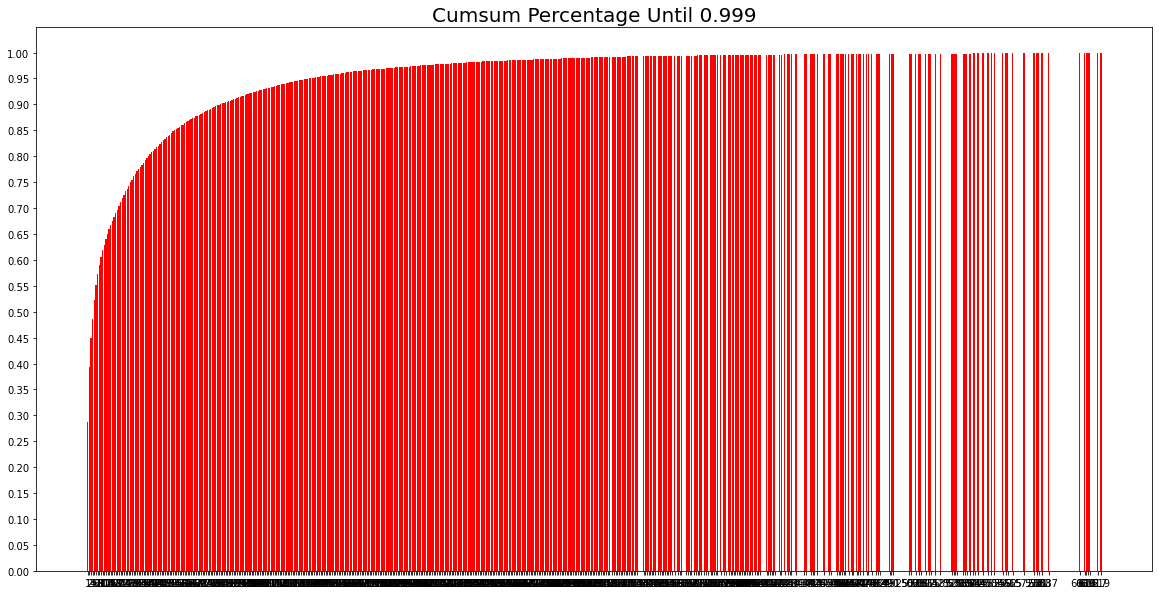

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

시간

In [16]:
oldest, latest = data['DateTime'].min(), data['DateTime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터 클린징

In [17]:
data = data[data['Rating']>=3]

data

,UserId,ItemId,Rating,DateTime,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,34630
999988,6040,1921,4,2001-08-10 14:41:04,34630
1000172,6040,1784,3,2001-08-10 14:41:04,34630
1000167,6040,161,3,2001-08-10 14:41:26,34630


미니배치 구성

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['DateTime'].max()
    session_last_time = data.groupby('SessionId')['DateTime'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=150)
tr, val = split_by_date(tr, n_days=150)

In [20]:
test

,UserId,ItemId,Rating,DateTime,SessionId
5200,36,2269,5,2002-12-22 08:05:50,137
5256,36,1701,4,2002-12-22 08:05:50,137
5184,36,2694,3,2002-12-22 08:08:14,137
5364,36,3786,4,2002-12-22 08:08:41,137
5262,36,2369,4,2002-12-22 08:09:24,137
...,...,...,...,...,...
984682,5950,3578,4,2003-02-27 18:14:30,34234
984475,5950,3793,3,2003-02-27 18:15:10,34234
984733,5950,1262,4,2003-02-27 18:17:38,34234
992459,5996,339,4,2002-10-07 13:24:39,34478


In [21]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["DateTime"].min()}\n'
          f'\t Last Time : {data["DateTime"].max()}\n')

In [22]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 823348
	 Sessions: 29874
	 Items: 3620
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-05-04 09:26:12

* valid Set Stats Info
	 Events: 6906
	 Sessions: 1706
	 Items: 2075
	 First Time : 2002-05-04 21:11:01
	 Last Time : 2002-10-01 09:36:33

* test Set Stats Info
	 Events: 6216
	 Sessions: 1304
	 Items: 1915
	 First Time : 2002-10-01 19:26:51
	 Last Time : 2003-02-28 17:49:50



In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [25]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [26]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.tail(10)

,UserId,ItemId,Rating,DateTime,SessionId,item_idx
1000169,6040,2725,4,2001-08-10 14:36:20,34630,1775
1000105,6040,1673,4,2001-08-10 14:36:52,34630,404
1000118,6040,457,4,2001-08-10 14:39:09,34630,124
1000119,6040,3671,4,2001-08-10 14:39:27,34630,168
999923,6040,232,5,2001-08-10 14:39:58,34630,978
1000019,6040,2917,4,2001-08-10 14:40:29,34630,1104
999988,6040,1921,4,2001-08-10 14:41:04,34630,315
1000172,6040,1784,3,2001-08-10 14:41:04,34630,87
1000167,6040,161,3,2001-08-10 14:41:26,34630,410
1000042,6040,1221,4,2001-08-20 13:44:15,34631,371


In [27]:
tr_dataset.click_offsets

array([     0,      7,     12, ..., 823326, 823347, 823348], dtype=int32)

In [28]:
tr_dataset.session_idx

array([    0,     1,     2, ..., 29871, 29872, 29873])

In [29]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [30]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,DateTime,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,0
22,1,1270,5,2000-12-31 22:00:55,1,1
27,1,1721,4,2000-12-31 22:00:55,1,2
37,1,1022,5,2000-12-31 22:00:55,1,3
24,1,2340,3,2000-12-31 22:01:43,1,4
36,1,1836,5,2000-12-31 22:02:52,1,5
3,1,3408,4,2000-12-31 22:04:35,1,6
7,1,2804,5,2000-12-31 22:11:59,2,7
47,1,1207,4,2000-12-31 22:11:59,2,8
0,1,1193,5,2000-12-31 22:12:40,2,9


In [31]:
iter_ex = iter(tr_data_loader)

In [32]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  7 12 40]
Label Item Idx are :       [ 1  8 13 41]
Previous Masked Input Idx are []


모델 구성

In [33]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [35]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [36]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [37]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3620)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    550800    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3620)               184620    
Total params: 735,420
Trainable params: 735,420
Non-trainable params: 0
_________________________________________________________________


모델 학습

In [38]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [39]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/3099 [00:00<?, ?it/s, accuracy=0.0117, train_loss=6.68] 

	 - Recall@20 epoch 1: 0.040179
	 - MRR@20    epoch 1: 0.011337



Train:   0%|          | 0/3099 [00:00<?, ?it/s, accuracy=0.0352, train_loss=6]   

	 - Recall@20 epoch 2: 0.084263
	 - MRR@20    epoch 2: 0.020697



Train:   0%|          | 0/3099 [00:00<?, ?it/s, accuracy=0.0273, train_loss=6.15]

	 - Recall@20 epoch 3: 0.094866
	 - MRR@20    epoch 3: 0.024785



Train:   0%|          | 0/3099 [00:00<?, ?it/s, accuracy=0.043, train_loss=6.11] 

	 - Recall@20 epoch 4: 0.107701
	 - MRR@20    epoch 4: 0.028718



Evaluation:  35%|███▌      | 7/20 [00:13<00:24,  1.90s/it]

	 - Recall@20 epoch 5: 0.110491
	 - MRR@20    epoch 5: 0.031893



모델 테스트

In [40]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  26%|██▋       | 5/19 [00:09<00:25,  1.81s/it]

	 - Recall@20: 0.144531
	 - MRR@20: 0.049093

